# Decision Tree, RandomForest and Gradient Boosting Classifier

## Overall approach
> * Split dataset is Train, Validation and Test
### For each model
> * Create a pipeline
* Define key hyperparameters to be optimized
* Find the best combination of hyperparameters
* Plot the accuracy on test and validation dataset
### Conclusion
> * Apply Best Model from each class to the master Train/Test datasets
* Save results for further comparison and decision

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid

from sklearn import datasets
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.datasets import make_circles
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

import tensorflow as tf

import random
from sklearn import ensemble

import warnings
warnings.filterwarnings("ignore")

# Activate Seaborn style
sns.set()

C:\Users\fbaff\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fbaff\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fbaff\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fbaff\AppData\Roaming\Python\Python36\site-

## Import data

In [2]:
# Load the npz file
with np.load('C:/Users/fbaff/EPFL ML Python/4- Machine Learning 2/ML 2 Project/Cifar4-train.npz', allow_pickle=False) as cifar_df:
    # It's a dictionary-like object
    cifar4 = dict(cifar_df.items())

## Create X/y arrays

In [3]:
X=cifar4['overfeat']
y=cifar4['labels']
names=cifar4['names']

print(X.shape, X.dtype)
print(y.shape, y.dtype)
print(names.shape, names.dtype)

(5000, 4096) float32
(5000,) int64
(4,) <U8


## Split data into Train/Test sets

In [4]:
# Convert the type of the input matrix to float
X = X.astype(np.float)

# Create train set
X_tr_main, X_test, y_tr_main, y_test = train_test_split(X,
    y,
    test_size=1000, random_state=0)

# Create validation and test sets
X_tr_2nd, X_valid, y_tr_2nd, y_valid = train_test_split(
    X_tr_main, y_tr_main, test_size=800, random_state=0)

print('Train:', X_tr_main.shape, y_tr_main.shape)
print('Test:', X_test.shape, y_test.shape)
print('Train2:', X_tr_2nd.shape, y_tr_2nd.shape)
print('Valid:', X_valid.shape, y_valid.shape)

Train: (4000, 4096) (4000,)
Test: (1000, 4096) (1000,)
Train2: (3200, 4096) (3200,)
Valid: (800, 4096) (800,)


## Create a pipeline for DecisionTreeClassifier

In [5]:
# Create Decision Tree pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()), # with standardization StandardScaler()
    ('PCA', PCA(n_components=175)), # 175 components to explain 90% of the variance (ref. Data Exploration section)
    ('clf', DecisionTreeClassifier(random_state=0))   
])

In [6]:
pipe.get_params()

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('PCA',
   PCA(copy=True, iterated_power='auto', n_components=175, random_state=None,
       svd_solver='auto', tol=0.0, whiten=False)),
  ('clf',
   DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, presort=False,
                          random_state=0, splitter='best'))],
 'verbose': False,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'PCA': PCA(copy=True, iterated_power='auto', n_components=175, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False),
 'clf': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        

### Define key parameters for the Decision Tree Classifier

In [7]:
# Grid of parameters
grid = ParameterGrid({
    'clf__max_depth': [2,3,5,7,10,12,15,20,30,40], # depth of trees
    'clf__criterion': ['gini'], # quality of the split (# remove entropy)
})

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 10


### Run the Decision Tree model on sub-train data set (3200 data points) and test accuracy on the validation data set (800 data points)

In [8]:
#  Save accuracy on train and validation sets
train_scores=[]
valid_scores = []

# Enumerate combinations starting from 1
for i, params_dict in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))
    
    # Set parameters
    pipe.set_params(**params_dict)

    # Fit a Decision Tree classifier
    pipe.fit(X_tr_2nd, y_tr_2nd) # Train2 3200 data points

    # Save accuracy on validation set   
    params_dict['accuracy_train']= pipe.score(X_tr_2nd, y_tr_2nd)
    params_dict['accuracy_valid'] = pipe.score(X_valid, y_valid)
    
    # Save result
    train_scores.append(params_dict)
    valid_scores.append(params_dict)

print('done')

Combination 1/10
Combination 2/10
Combination 3/10
Combination 4/10
Combination 5/10
Combination 6/10
Combination 7/10
Combination 8/10
Combination 9/10
Combination 10/10
done


In [9]:
# Create DataFrame with test scores
scores_df = pd.DataFrame(valid_scores)
# Print scores
scores_df.sort_values(by='accuracy_valid', ascending=False)

,clf__criterion,clf__max_depth,accuracy_train,accuracy_valid
2,gini,5,0.721562,0.66375
3,gini,7,0.816875,0.63375
1,gini,3,0.662813,0.62875
0,gini,2,0.617500,0.60875
5,gini,12,0.970625,0.59875
4,gini,10,0.940625,0.59500
6,gini,15,0.986875,0.59500
7,gini,20,0.995938,0.58625
9,gini,40,1.000000,0.57375
8,gini,30,1.000000,0.54750


#### Find the best combination of parameters

In [10]:
# Find best combination
idx = np.argmax(scores_df['accuracy_valid'])
print('Top validation accuracy on set {:}'.format(idx))

print('Accuracy on validation set {:.3f}'.format(
     scores_df.accuracy_valid[idx]
     ))

# Print depth of tree for the best combination
print('Decision tree with depth {:}'.format(
    scores_df.clf__max_depth[idx], 
))


Top validation accuracy on set 2
Accuracy on validation set 0.664
Decision tree with depth 5


#### Plot accuracy for train and validation data sets

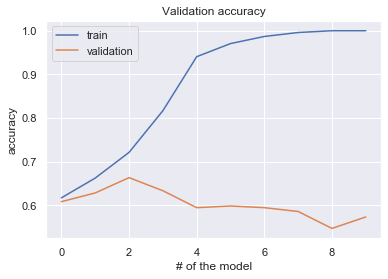

In [11]:
# Plot accuracy values
plt.plot(scores_df['accuracy_train'], label='train')
plt.plot(scores_df['accuracy_valid'], label='validation')
plt.title('Validation accuracy')
plt.xlabel('# of the model')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### Conclusions about Decision Tree
* **Best results: Accuracy on valid set = 0.66 with Gini quality of split and tree depth of 5 (StandardScaler and PCA explaining 90% of the variance have been applied)**
* **Selected model is the one being the best in terms of generalization as both validation/train curves are the closest among all tested decion tree models**

## Create a classifier for Random Forest

In [12]:
# Create Random Forest pipeline
pipe2 = Pipeline([
    ('scaler', StandardScaler()), # with standardization StandardScaler()
    ('PCA', PCA(n_components=175)), # 175 components to explain 90% of the variance (ref. Data Exploration section)
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=0))  
])

In [13]:
pipe2.get_params()

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('PCA',
   PCA(copy=True, iterated_power='auto', n_components=175, random_state=None,
       svd_solver='auto', tol=0.0, whiten=False)),
  ('rf',
   RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                          max_depth=None, max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators='warn',
                          n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                          warm_start=False))],
 'verbose': False,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'PCA': PCA(copy=True, iterated_power='auto', n_components=175, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False),
 'rf': RandomForest

### Define key parameters for the Random Forest Classifier

In [14]:
# Grid of parameters
grid2 = ParameterGrid({
    'rf__n_estimators': [800,1000], # of decision trees
    'rf__criterion': ['gini'], # quality of split (Gini provided better results in previous runs than entropy)
    'rf__max_features':[0.3,0.5,0.8], # % of features vs total number of features for looking at the best split
    'rf__max_depth':[5,10,20], # depth of trees
})

# Print the number of combinations
print('Number of combinations:', len(grid2))

Number of combinations: 18


### Run the Random Forest model on sub-train data set (3200 data points) and test accuracy on the validation data set (800 data points)

In [15]:
#  Save accuracy on train and validation sets
train_scores=[]
valid_scores = []

# Enumerate combinations starting from 1
for i, params_dict in enumerate(grid2, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid2) # Total number of combinations
    ))
    
    # Set parameters
    pipe2.set_params(**params_dict)

    # Fit a Decision Tree classifier
    pipe2.fit(X_tr_2nd, y_tr_2nd) # Train2 3200 data points

    # Save accuracy on validation set   
    params_dict['accuracy_train']= pipe2.score(X_tr_2nd, y_tr_2nd)
    params_dict['accuracy_valid'] = pipe2.score(X_valid, y_valid)
    
    # Save result
    train_scores.append(params_dict)
    valid_scores.append(params_dict)

print('done')

Combination 1/18
Combination 2/18
Combination 3/18
Combination 4/18
Combination 5/18
Combination 6/18
Combination 7/18
Combination 8/18
Combination 9/18
Combination 10/18
Combination 11/18
Combination 12/18
Combination 13/18
Combination 14/18
Combination 15/18
Combination 16/18
Combination 17/18
Combination 18/18
done


In [16]:
# Create DataFrame with test scores
scores_rf = pd.DataFrame(valid_scores)
# Print scores
scores_rf.sort_values(by='accuracy_valid', ascending=False)

,rf__criterion,rf__max_depth,rf__max_features,rf__n_estimators,accuracy_train,accuracy_valid
12,gini,20,0.3,800,1.000000,0.76000
13,gini,20,0.3,1000,1.000000,0.75375
6,gini,10,0.3,800,0.990938,0.75250
7,gini,10,0.3,1000,0.990625,0.75125
8,gini,10,0.5,800,0.985938,0.74125
9,gini,10,0.5,1000,0.985000,0.73875
15,gini,20,0.5,1000,1.000000,0.73875
14,gini,20,0.5,800,1.000000,0.73625
16,gini,20,0.8,800,1.000000,0.73000
1,gini,5,0.3,1000,0.780000,0.72750


#### Find the best combination of parameters

In [17]:
# Find best combination
idx = np.argmax(scores_rf['accuracy_valid'])
print('Top validation accuracy on set {:}'.format(idx))

# Print accuracy on validation set
print('Accuracy on validation set {:.3f}'.format(
     scores_rf.accuracy_valid[idx]
     ))

# Print type of quality of split
print('Type of quality of split {:}'.format(
    scores_rf.rf__criterion[idx], 
))

# Print # of decision trees for the best combination
print('Decision tree with depth {:}'.format(
    scores_rf.rf__n_estimators[idx], 
))

Top validation accuracy on set 12
Accuracy on validation set 0.760
Type of quality of split gini
Decision tree with depth 800


#### Plot accuracy on train and validation data sets

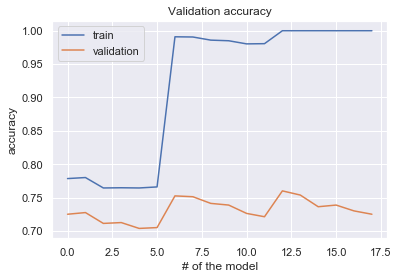

In [18]:
# Plot accuracy values
plt.plot(scores_rf['accuracy_train'], label='train')
plt.plot(scores_rf['accuracy_valid'], label='validation')
plt.title('Validation accuracy')
plt.xlabel('# of the model')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### Conclusions about Random Forest Classifier
* **Best 1st results (2 parameters: n_estimators & criterion): Accuracy on valid set = 0.792 with Gini type of quality split and 800 decision trees (out of a maximumn of 1000) BUT high-level of overfitting**
* **Best 2nd results (3 parameters: n_estimators, mx_features, max_depth): Selection of the model minimizing the variance between train & validation: Model 1 (gini criterion, 1000 estimators, 30% max_features, 5 mx_depth)**
    * Accuracy on validation 0.7275, accuracy on train set 0.779

# Create Gradient Boosting classifier

In [19]:
# Create pipeline
pipe3 = Pipeline([
    ('scaler', StandardScaler()), # with standardization StandardScaler()
    ('PCA', PCA(n_components=175)), # 175 components to explain 90% of the variance (ref. Data Exploration section)
    ('gb', ensemble.GradientBoostingClassifier(random_state=0)) # Loss by default is 'deviance' (logistic regression), 'exponential' will induce  AdaBoosting classifier  
])

In [20]:
pipe3.get_params()

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('PCA',
   PCA(copy=True, iterated_power='auto', n_components=175, random_state=None,
       svd_solver='auto', tol=0.0, whiten=False)),
  ('gb', GradientBoostingClassifier(criterion='friedman_mse', init=None,
                              learning_rate=0.1, loss='deviance', max_depth=3,
                              max_features=None, max_leaf_nodes=None,
                              min_impurity_decrease=0.0, min_impurity_split=None,
                              min_samples_leaf=1, min_samples_split=2,
                              min_weight_fraction_leaf=0.0, n_estimators=100,
                              n_iter_no_change=None, presort='auto',
                              random_state=0, subsample=1.0, tol=0.0001,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False))],
 'verbose': False,
 'scaler': StandardScaler(cop

In [21]:
# Grid of parameters
grid3 = ParameterGrid({
    'gb__learning_rate':[0.2,0.1,0.01], # learning rate
    'gb__n_estimators': [500, 800, 1000] # of boosting stages
})

# Print the number of combinations
print('Number of combinations:', len(grid3))

Number of combinations: 9


### Run the Gradient Boosting model on sub-train data set (3200 data points) and test accuracy on the validation data set (800 data points)

In [22]:
# Save accuracy on train and validation sets
train_scores=[]
valid_scores = []

# Enumerate combinations starting from 1
for i, params_dict in enumerate(grid3, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid3) # Total number of combinations
    ))
    
    # Set parameters
    pipe3.set_params(**params_dict)

    # Fit a Decision Tree classifier
    pipe3.fit(X_tr_2nd, y_tr_2nd) # Train2 3200 data points

    # Save accuracy on validation set   
    params_dict['accuracy_train']= pipe3.score(X_tr_2nd, y_tr_2nd)
    params_dict['accuracy_valid'] = pipe3.score(X_valid, y_valid)
    
    # Save result
    train_scores.append(params_dict)
    valid_scores.append(params_dict)

print('done')

Combination 1/9
Combination 2/9
Combination 3/9
Combination 4/9
Combination 5/9
Combination 6/9
Combination 7/9
Combination 8/9
Combination 9/9
done


#### Create a dataframe with results

In [23]:
# Create DataFrame with test scores
scores_gb = pd.DataFrame(valid_scores)
# Print scores
scores_gb.sort_values(by='accuracy_valid', ascending=False)

,gb__learning_rate,gb__n_estimators,accuracy_train,accuracy_valid
3,0.10,500,1.000000,0.81000
0,0.20,500,1.000000,0.80750
2,0.20,1000,1.000000,0.80500
4,0.10,800,1.000000,0.80250
1,0.20,800,1.000000,0.80000
5,0.10,1000,1.000000,0.79750
8,0.01,1000,0.965625,0.77875
7,0.01,800,0.943125,0.77250
6,0.01,500,0.880313,0.75125


#### Find the best combination of parameters

In [24]:
# Find best combination
idx = np.argmax(scores_gb['accuracy_valid'])
print('Top validation accuracy on set {:}'.format(idx))

# Print accuracy on validation set
print('Accuracy on validation set {:.3f}'.format(
     scores_gb.accuracy_valid[idx]
     ))

# Print type of quality of split
print('Learning rate {:}'.format(
    scores_gb.gb__learning_rate[idx], 
))

# Print # of decision trees for the best combination
print('Number of estimators {:}'.format(
    scores_gb.gb__n_estimators[idx], 
))

Top validation accuracy on set 3
Accuracy on validation set 0.810
Learning rate 0.1
Number of estimators 500


#### Print accuracy on Train and Validation data sets

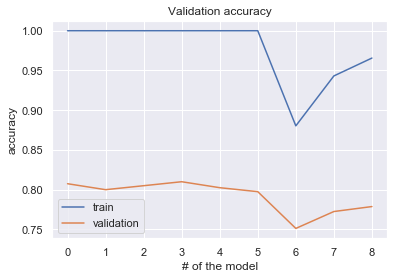

In [25]:
# Plot accuracy values
plt.plot(scores_gb['accuracy_train'], label='train')
plt.plot(scores_gb['accuracy_valid'], label='validation')
plt.title('Validation accuracy')
plt.xlabel('# of the model')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Apply best classifiers on Train / test sets

## Select best models

### **Decision tree**
* **Best results: Accuracy on valid set = 0.66 with Gini quality of split and tree depth of 5 (StandardScaler and PCA explaining 90% of the variance have been applied)**

In [26]:
# Create Decision Tree pipeline
pipe_dt_final = Pipeline([
    ('scaler', StandardScaler()), # with standardization StandardScaler()
    ('PCA', PCA(n_components=175)), # 175 components to explain 90% of the variance (ref. Data Exploration section)
    ('clf', DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=5))   
])

### Run the Decision Tree on X/Y data sets

In [27]:
# Fit a Decision Tree classifier
pipe_dt_final.fit(X_tr_main, y_tr_main) # Train 4000 data points

# Save accuracy on train and test set   
score_train=pipe_dt_final.score(X_tr_main, y_tr_main)
score_test=pipe_dt_final.score(X_test, y_test)

print('train accuracy', score_train)
print('test accuracy', score_test) 

train accuracy 0.715
test accuracy 0.641


### **RandomForest classifier**
**Best 2nd results (3 parameters: n_estimators, mx_features, max_depth): Selection of the model minimizing the variance between train & validation: Model 1 (gini criterion, 1000 estimators, 30% max_features, 5 mx_depth)**
    * Accuracy on validation 0.7275, accuracy on train set 0.779

In [28]:
# Create RandomForest pipeline
pipe_rf_final = Pipeline([
    ('scaler', StandardScaler()), # with standardization StandardScaler()
    ('PCA', PCA(n_components=175)), # 175 components to explain 90% of the variance (ref. Data Exploration section)
    ('rf', RandomForestClassifier(n_jobs=-1, n_estimators=1000, criterion='gini',max_features=0.3, max_depth=5,random_state=0))  
])

In [29]:
# Fit a randomForest classifier
pipe_rf_final.fit(X_tr_main, y_tr_main) # Train 4000 data points

# Save accuracy on train and test set   
score_train=pipe_rf_final.score(X_tr_main, y_tr_main)
score_test=pipe_rf_final.score(X_test, y_test)

print('train accuracy', score_train)
print('test accuracy', score_test)

train accuracy 0.76325
test accuracy 0.709


### Gradient Boosting Model
**Best Model: Learning rate 0.2, Number of estimators 1000**
    * Accuracy on validation 0.8075, accuracy on train set 1.00

In [30]:
# Create Gradient Boosting pipeline
pipe_gb_final = Pipeline([
    ('scaler', StandardScaler()), # with standardization StandardScaler()
    ('PCA', PCA(n_components=175)), # 175 components to explain 90% of the variance (ref. Data Exploration section)
    ('gb', ensemble.GradientBoostingClassifier(learning_rate=0.2, n_estimators=1000, random_state=0))  
])

In [31]:
# Fit Gradient Boosting Model
pipe_gb_final.fit(X_tr_main, y_tr_main) # Train 4000 data points

# Save accuracy on train and test set   
score_train=pipe_gb_final.score(X_tr_main, y_tr_main)
score_test=pipe_gb_final.score(X_test, y_test)

print('train accuracy', score_train)
print('test accuracy', score_test)

train accuracy 1.0
test accuracy 0.794


### Save DecisionTee results

In [33]:
DecisionTree=0.641
%store DecisionTree

RandomForest=0.709
%store RandomForest

GradientBoosting=0.794
%store GradientBoosting


Stored 'DecisionTree' (float)
Stored 'RandomForest' (float)
Stored 'GradientBoosting' (float)
